Using the Movielens dataset to build a Recommender system based on popular movies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Load Datasets

In [2]:
df_metadata= pd.read_csv('data/movies_metadata.csv', low_memory=False)
df_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
df_links= pd.read_csv('data/links_small.csv')
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

## Row Filtering

Note that 'id' column in df_metadata dataframe is of object type, this will affect the row filtering as object and float/integer data cannot be compared.

In [5]:
# preping 'id' column of df_metadata to numeric, to enable row filtering with df_links.tmdbId column
#change all data to integer in id column of df_metadata
# while missing and empty rows are replaced with null value

i = 0
for x in df_metadata['id']:
    if x.isdigit()==False:
        df_metadata.loc[i, 'id']= np.nan
    else:
        df_metadata.loc[i, 'id']= int(df_metadata.loc[i, 'id'])
    i=i+1

In [6]:
ids= df_links['tmdbId'].tolist()
df_metadata1= df_metadata[df_metadata['id'].isin(ids)]
df_metadata1.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## Feature Selection

In [7]:
#selecting only useful columns for popularity recommendation
popular_df=df_metadata1[['id', 'title', 'popularity', 'homepage']]
popular_df.head(3)

,id,title,popularity,homepage
0,862,Toy Story,21.946943,http://toystory.disney.com/toy-story
1,8844,Jumanji,17.015539,NaN
2,15602,Grumpier Old Men,11.7129,NaN


## Data Analysis

In [8]:
popular_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9102 entries, 0 to 45265
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          9099 non-null   object
 1   title       9099 non-null   object
 2   popularity  9100 non-null   object
 3   homepage    1977 non-null   object
dtypes: object(4)
memory usage: 355.5+ KB


In [9]:
popular_df.dtypes

id            object
title         object
popularity    object
homepage      object
dtype: object

NB: The popuarity feature in our dataframe has to be in float type 

In [10]:
# using exception handling to create a function that gives out True for float values
def isFloat(x):
    try:
        float(x)
        return True
    except ValueError:
        return False


In [11]:
# creating a list to carry the float values of df['popularity']

popular=[]
for x in popular_df['popularity']:
    if type(x) != float and isFloat(x)==False:
        x=float(np.nan)
        popular.append(x)
    elif type(x) != float and isFloat(x)==True:
        x=float(x)
        popular.append(x)
    else:
        popular.append(x)



In [12]:
popular_df['popularity']=popular
popular_df.dtypes

id             object
title          object
popularity    float64
homepage       object
dtype: object

Note: popularity column has been successfully converted to a float type

In [13]:
# drop duplicate rows
popular_df.drop_duplicates(keep=False, inplace=True)

In [15]:
# handling missing values
popular_df['homepage']=popular_df['homepage'].fillna('Not available')


In [16]:
#drop all rows with missing title
popular_df=popular_df.dropna(subset=['title'])

In [17]:
popular_df.isnull().sum()

id            0
title         0
popularity    0
homepage      0
dtype: int64

## Recommendation

In [18]:
popular_df=popular_df.sort_values(by='popularity', ascending=False)
popular_df.to_csv('../cleaned_data/popular_df.csv')
popular_df

,id,title,popularity,homepage
30700,211672,Minions,547.488298,http://www.minionsmovie.com/
24455,177572,Big Hero 6,213.849907,http://movies.disney.com/big-hero-6
26564,293660,Deadpool,187.860492,http://www.foxmovies.com/movies/deadpool
14551,19995,Avatar,185.070892,http://www.avatarmovie.com/
24351,245891,John Wick,183.870374,http://www.johnwickthemovie.com/
...,...,...,...,...
800,12632,Kaspar Hauser,0.000578,Not available
772,124306,My Life and Times With Antonin Artaud,0.000308,Not available
13533,62437,Land of Silence and Darkness,0.000220,Not available
565,53185,Wide Eyed and Legless,0.000150,Not available


Text(0.5, 1.0, 'Best movie by Popuarity')

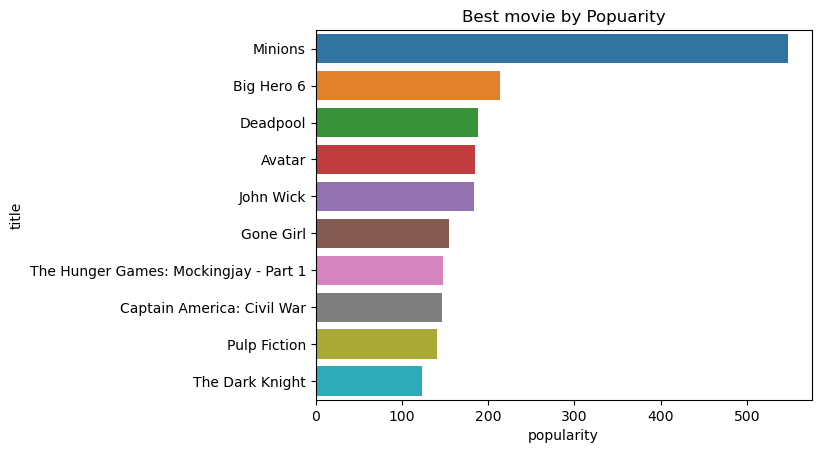

In [19]:
sns.barplot(x= popular_df['popularity'].head(10), y= popular_df['title'].head(10))
plt.title('Best movie by Popuarity')

In [20]:
def popular_recommender(popular_df):
    print("Popular movies right now...")
    recommend_movies=popular_df.head()['title'].tolist()
    recommend_homepage=popular_df.head()['homepage'].tolist()
    recommendation=[]
    for i in range(0, len(recommend_movies)):
        recommendation.append({recommend_movies[i]: recommend_homepage[i]})

    return recommendation
    
popular_recommender(popular_df)

Popular movies right now...


[{'Minions': 'http://www.minionsmovie.com/'},
 {'Big Hero 6': 'http://movies.disney.com/big-hero-6'},
 {'Deadpool': 'http://www.foxmovies.com/movies/deadpool'},
 {'Avatar': 'http://www.avatarmovie.com/'},
 {'John Wick': 'http://www.johnwickthemovie.com/'}]